# Models testing

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, Dropout, ReLU, LSTM, SimpleRNN
from tensorflow.keras.layers import Concatenate, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
# Printing
import pprint
import matplotlib.pyplot as plt             
import sys

sys.path.append('../scripts/')

from sklearn.metrics import mean_squared_error

import datetime
from datetime import timedelta

from models import BaseModels, DataCleaner, ModelPlots, DataModel

In [2]:
#speeds = pd.read_pickle('data/speeds1419.pckl')
#speeds80 = speeds.groupby('data/matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns)))


mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")

mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)
updatedSpeed = pd.read_pickle("../data/updatedSpeedWithHistoricalValues1419.pckl")

counts = pd.read_pickle('../data/counts1419.pckl')
updatedcounts = counts.assign(newIndex = mergedIndex.reindex(counts.index).values)
updatedcounts = updatedcounts[~updatedcounts.newIndex.isna()]
updatedcounts = updatedcounts.groupby('newIndex').sum().loc[updatedSpeed.index]

updatedSpeed = pd.read_pickle("../data/updatedSpeedWithHistoricalValues1419.pckl")

In [5]:
updatedSpeed.head()

time,2018-11-13 14:00:00,2018-11-13 14:15:00,2018-11-13 14:30:00,2018-11-13 14:45:00,2018-11-13 15:00:00,2018-11-13 15:15:00,2018-11-13 15:30:00,2018-11-13 15:45:00,2018-11-13 16:00:00,2018-11-13 16:15:00,...,2018-12-11 16:30:00,2018-12-11 16:45:00,2018-12-11 17:00:00,2018-12-11 17:15:00,2018-12-11 17:30:00,2018-12-11 17:45:00,2018-12-11 18:00:00,2018-12-11 18:15:00,2018-12-11 18:30:00,2018-12-11 18:45:00
newIndex,,,,,,,,,,,,,,,,,,,,,
10275171_0,6.000000,13.500000,6.487879,12.333333,10.000000,2.500000,10.000000,3.8875,3.750000,3.875000,...,0.000000,7.500000,5.750000,2.285714,12.500000,4.000000,3.850000,1.444444,6.000000,3.000000
11027377_0,38.000000,17.000000,11.500000,25.198313,22.916667,7.000000,4.666667,13.5000,46.500000,17.828788,...,12.766667,8.000000,20.000000,35.000000,25.375000,19.500000,38.000000,4.000000,0.000000,12.500000
11027379_0,80.166667,72.750000,72.000000,75.200000,78.000000,69.833333,63.666667,73.6250,82.000000,70.285714,...,71.500000,69.000000,55.250000,72.000000,75.666667,76.777778,50.500000,89.750000,60.000000,71.125000
111437857_0,84.707242,89.400000,94.000000,76.333333,87.500000,74.750000,95.000000,77.5000,44.500000,19.000000,...,6.800000,24.625000,8.333333,15.833333,15.000000,48.500000,86.000000,70.500000,55.000000,62.476190
111848631_0,102.746479,102.333333,101.183099,100.279070,101.642857,98.578313,109.395349,111.0000,109.882353,109.030303,...,108.959184,107.123457,106.111111,109.049180,112.061224,113.850575,113.764706,117.500000,116.323529,109.552632


In [7]:
input_lag, output_lag, sequence_length, valid_split =  2, 1, 20, 0.6

data_model = PredictionModel(updatedSpeed, input_lag, output_lag, sequence_length, valid_split= valid_split)
data_model.preprocessData()
x_train, y_train, x_test, y_test = data_model.trainSplit()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (140, 2, 748)
y_train shape: (140, 748)
x_test shape: (94, 2, 748)
y_test shape: (94, 748)


In [4]:
historic_data = updatedSpeed.iloc[:,:x_train.shape[0]]
#historic_data.head()

array([  7.14108144,  19.3519987 ,  67.90964333,  63.51588371,
       104.78119663, 106.32946347, 110.02562209,  36.05130318,
        42.29451698,  41.83360132,  48.50731047,  95.99765442,
        98.16563147,  31.52240816,  67.55925677,  61.99056548,
        67.3387698 ,  69.0894669 ,  35.85302069,  71.24602893,
        72.21719263,  17.23443743, 104.45684283, 108.59153278,
       112.84447459, 110.48962827, 107.28135949, 101.76259136,
        78.80379983,  73.1583065 ,  82.0117844 ,  52.41389624,
        38.08327548,   7.21725652,  37.4695784 ,  98.96024343,
        92.99571431,  20.07905606,  99.45279305,  64.27425022,
        81.87004098,  77.70246339,  15.96568346,  16.80530777,
        93.0916595 ,  71.11135229,  73.02268236,  31.33461688,
        68.91773812,  78.89538706,  64.9895089 ,  63.88064877,
        83.31028304,  26.92819092,  39.32334981,  44.56074437,
        57.79086851,  14.13169816,  27.417939  ,  22.5550749 ,
       109.07370596, 102.76979423, 112.06639693, 111.85

In [8]:
train = updatedSpeed.iloc[:,:250].values
train_dates = updatedSpeed.columns[:250]
test = updatedSpeed.iloc[:,250:]
test_dates = updatedSpeed.columns[250:].values
train.shape, test.shape

((748, 250), (748, 10))

In [6]:
def createMlpModel(loss='MSE',optimizer='Adam', nlayers=1, neuronsPerLayer=64, relu_output=False, nSegments=748):
    
    inputs = Input(shape=(nSegments,), name='input')
    x = Flatten(name='flatten')(inputs)
    
    for i in range(nlayers):    
        x = Dense(neuronsPerLayer/(i+1))(x)
        
    if relu_output :
        predictions = Dense(nSegments, activation='relu', name='out_layer')(x)
    else:
        predictions = Dense(nSegments, name='out_layer')(x)
        
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [37]:
data_model.model = createMlpModel(nlayers=1, neuronsPerLayer=64, relu_output=False)
data_model.model.summary()
data_model.model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=40)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 748)               0         
_________________________________________________________________
flatten (Flatten)            (None, 748)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                47936     
_________________________________________________________________
out_layer (Dense)            (None, 748)               48620     
Total params: 96,556
Trainable params: 96,556
Non-trainable params: 0
_________________________________________________________________
Train on 148 samples, validate on 99 samples
Epoch 1/40
148/148 [==============================] - 0s 2ms/step - loss: 4388.5848 - val_loss: 3572.3161
Epoch 2/40
148/148 [==============================] - 0s 219us/step - loss: 2916.4394 - val_loss: 1874.6668
Epoch 3/40


In [26]:
tf.keras.backend.clear_session()

## Working Zone

In [2]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
speeds = pd.read_pickle("../data/monthsSpeed.pckl")
counts = pd.read_pickle('../data/monthsCount.pckl')
data_cleaner = DataCleaner(speeds, segmentsMeta, mergeResults, counts)
speedDF = data_cleaner.data
countDF = data_cleaner.counts

In [3]:
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67

data_model = DataModel(speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
data_model.preprocessData()

model = BaseModels("timeHistoric", speedDF[speedDF.columns[:int(len(speedDF.columns)*data_model.valid_split)]])
data_model.model = model

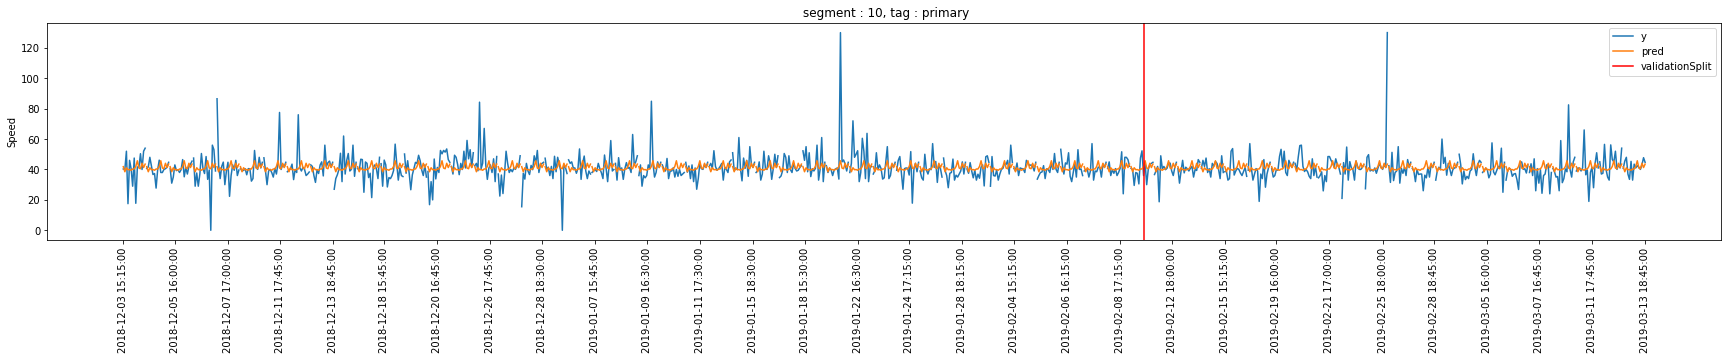

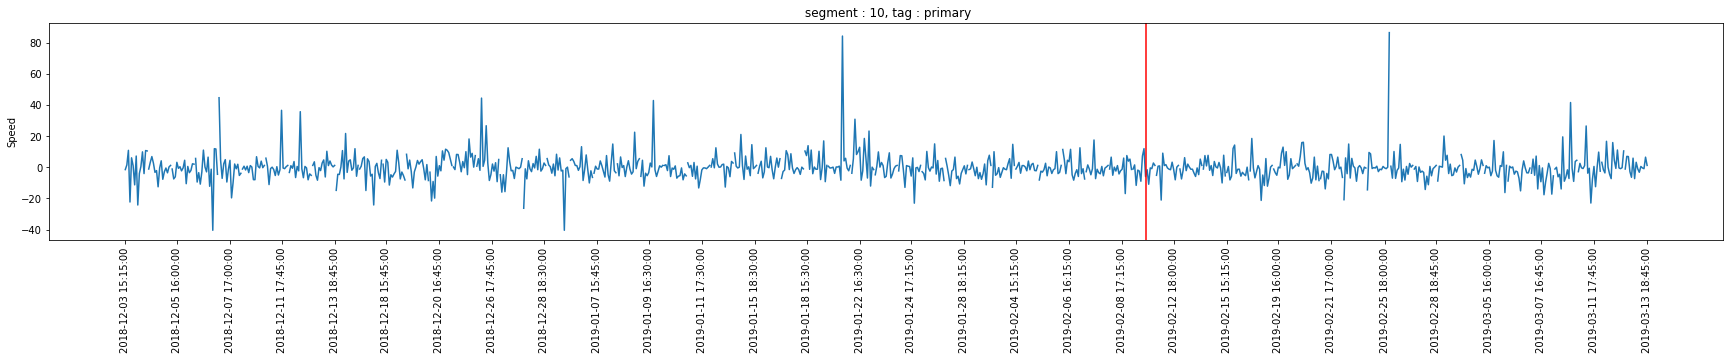

In [4]:
model_plotting = ModelPlots(data_model, data_cleaner)

model_plotting.plotSegmentSeries(10,plot_error=False)
model_plotting.plotSegmentSeries(10,plot_error=True)

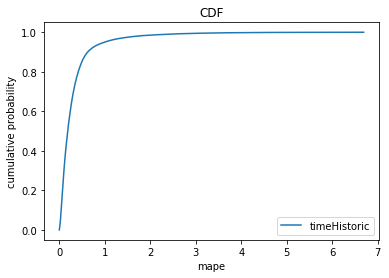

In [5]:
model_plotting.cdfPlot(label="timeHistoric")

### LSTM

In [6]:
data_model2 = DataModel(speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split, scale_max = True )
data_model2.preprocessData()
x_train, y_train, x_test, y_test = data_model2.trainSplit()

In [18]:
nSegments

692

In [12]:
model2 = Sequential()
model2.add(LSTM(500, return_sequences=True, input_shape=x_train.shape[1:]))
model2.add(Dropout(0.3))
model2.add(LSTM(500))
model2.add(Dense(500, activation = tf.keras.activations.sigmoid ))
model2.add(Dense(500, activation = tf.keras.activations.sigmoid ))
model2.add(Dense(nSegments))

model2.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam())

In [13]:
data_model2.model = model2
data_model2.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 500)            2386000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 500)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 692)               346692    
Total params: 5,235,692
Trainable params: 5,235,692
Non-trainable params: 0
_________________________________________________________________


In [14]:
modelHist = data_model2.model.fit([x_train],[y_train],validation_data=([x_test],y_test),epochs=20)

print(data_model2.mse(data_model2.predict('train'),y_train), data_model2.mse(data_model2.predict('test'),y_test))
print(data_model2.mae(data_model2.predict('train'),y_train), data_model2.mae(data_model2.predict('test'),y_test))

Train on 653 samples, validate on 322 samples
Epoch 1/20
653/653 [==============================] - 10s 15ms/step - loss: 0.0683 - val_loss: 0.0149
Epoch 2/20
653/653 [==============================] - 7s 11ms/step - loss: 0.0128 - val_loss: 0.0115
Epoch 3/20
653/653 [==============================] - 8s 13ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 4/20
653/653 [==============================] - 8s 12ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 5/20
653/653 [==============================] - 9s 14ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 6/20
653/653 [==============================] - 9s 14ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 7/20
653/653 [==============================] - 8s 13ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 8/20
653/653 [==============================] - 9s 14ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 9/20
653/653 [==============================] - 8s 13ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 10/20
653/653 [=======================

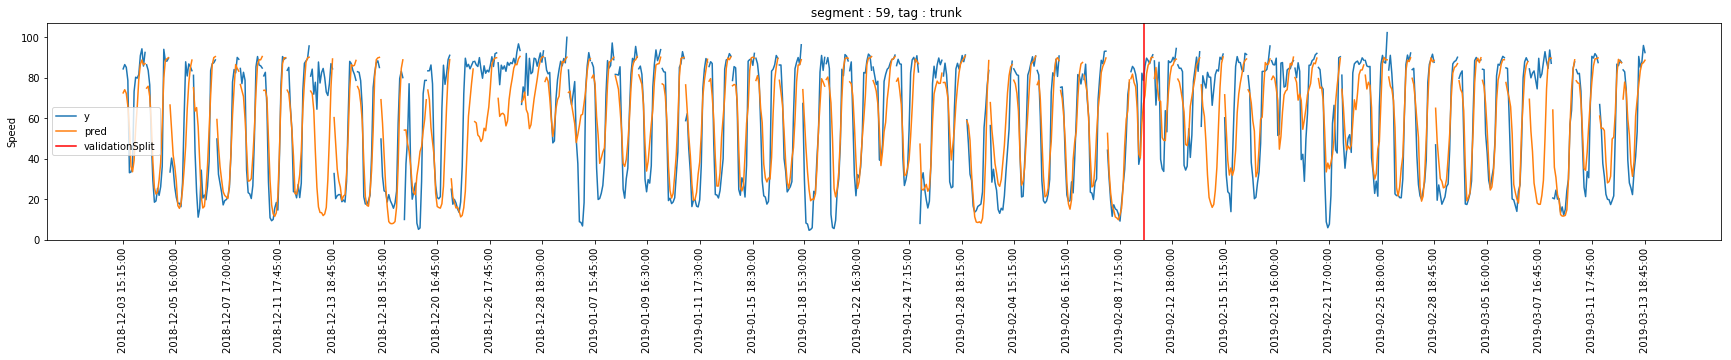

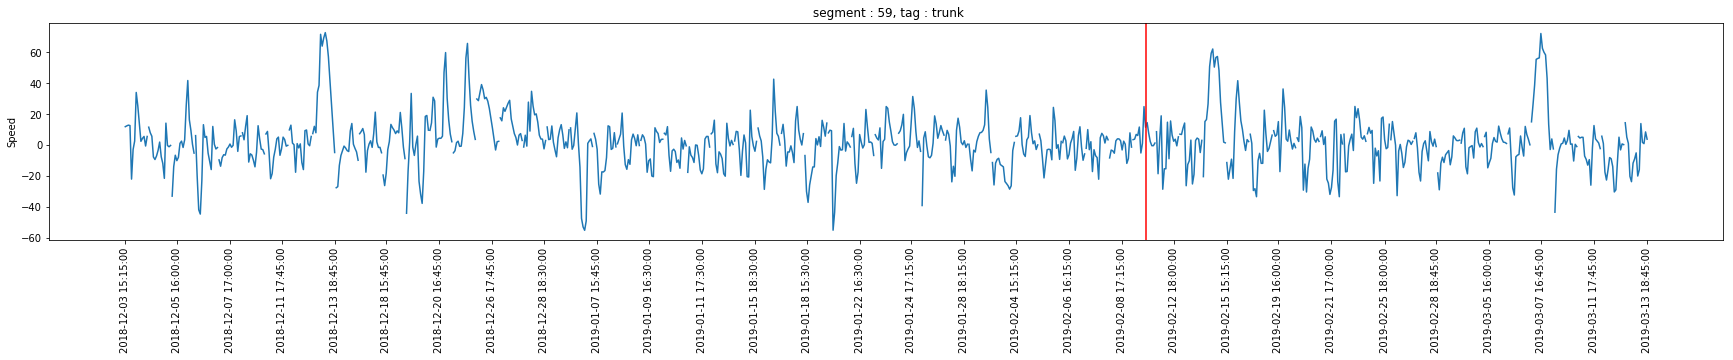

In [15]:
model_plotting2 = ModelPlots(data_model2, data_cleaner)

model_plotting2.plotSegmentSeries(59,plot_error=False)
model_plotting2.plotSegmentSeries(59,plot_error=True)

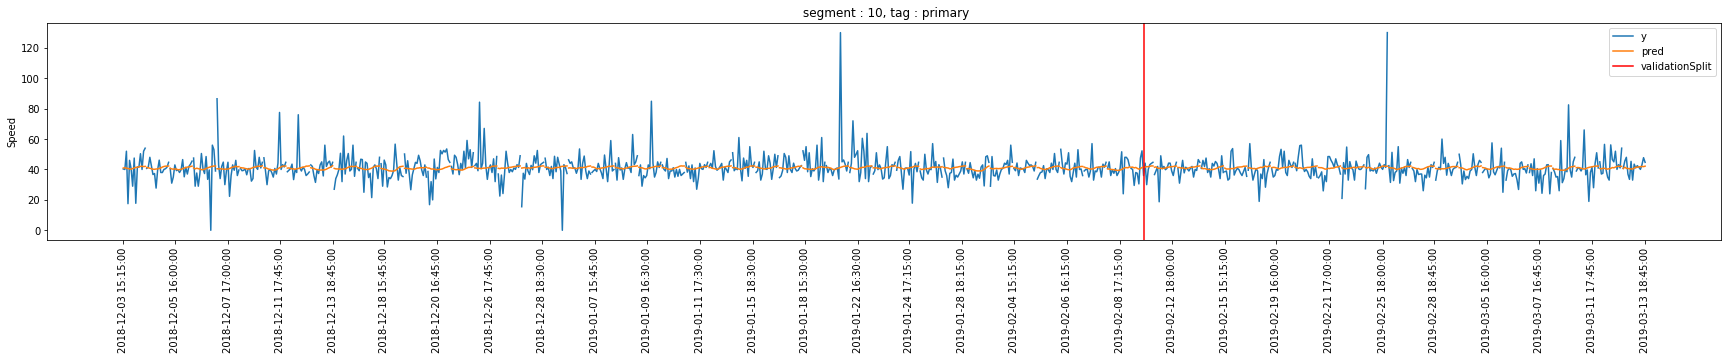

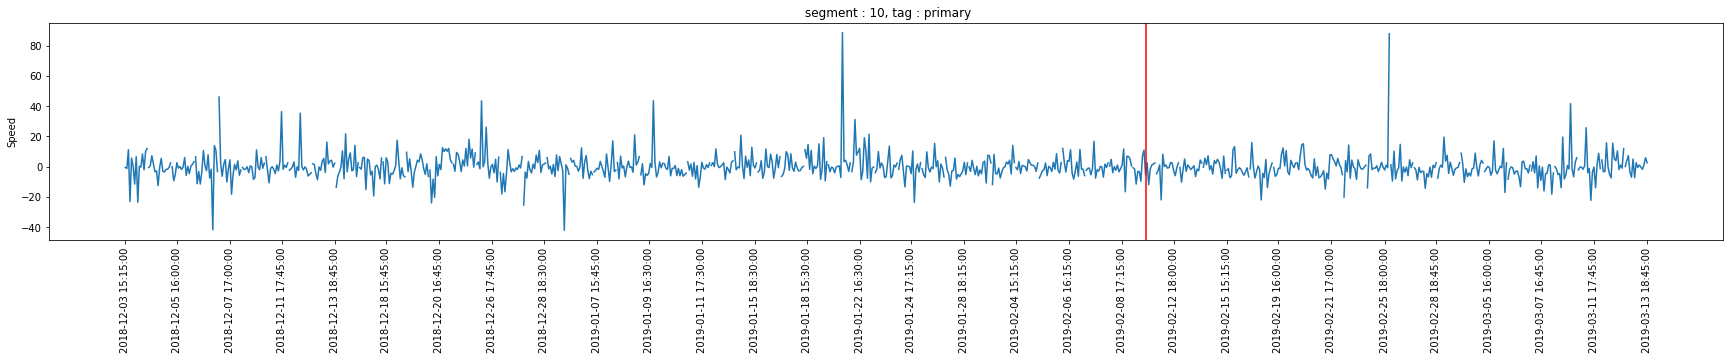

In [58]:
model_plotting = ModelPlots(data_model2, data_cleaner)

model_plotting.plotSegmentSeries(10,plot_error=False)
model_plotting.plotSegmentSeries(10,plot_error=True)

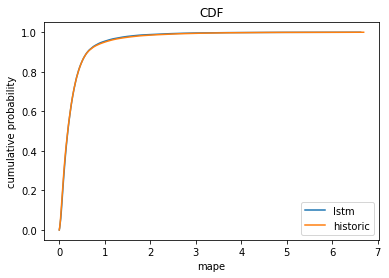

In [11]:
model_plotting2.cdfPlot(label="lstm")
model_plotting.cdfPlot(label="historic")

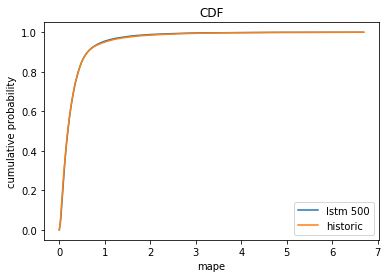

In [16]:
model_plotting2.cdfPlot(label="lstm 500")
model_plotting.cdfPlot(label="historic")

# RNN + Network

In [113]:
data_model3 = DataModel(speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split, scale_max = True )
data_model3.preprocessData()
x_train, y_train, x_test, y_test = data_model3.trainSplit()

In [114]:
model3 = Sequential()
model3.add(SimpleRNN(nSegments, return_sequences=False, input_shape=x_train.shape[1:]))
#model3.add(Dense(nSegments))

model3.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam())
data_model3.model = model3
data_model3.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_28 (SimpleRNN)    (None, 692)               958420    
Total params: 958,420
Trainable params: 958,420
Non-trainable params: 0
_________________________________________________________________


In [115]:
modelHist = data_model3.model.fit([x_train],[y_train],validation_data=([x_test],y_test), epochs=40)

print(data_model3.mse(data_model3.predict('train'),y_train), data_model3.mse(data_model3.predict('test'),y_test))
print(data_model3.mae(data_model3.predict('train'),y_train), data_model3.mae(data_model3.predict('test'),y_test))

Train on 653 samples, validate on 322 samples
Epoch 1/40
653/653 [==============================] - 6s 9ms/step - loss: 0.1034 - val_loss: 0.0317
Epoch 2/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0223
Epoch 3/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0195
Epoch 4/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 5/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0173
Epoch 6/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 7/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 8/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 9/40
653/653 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0155
Epoch 10/40
653/653 [==============================] -

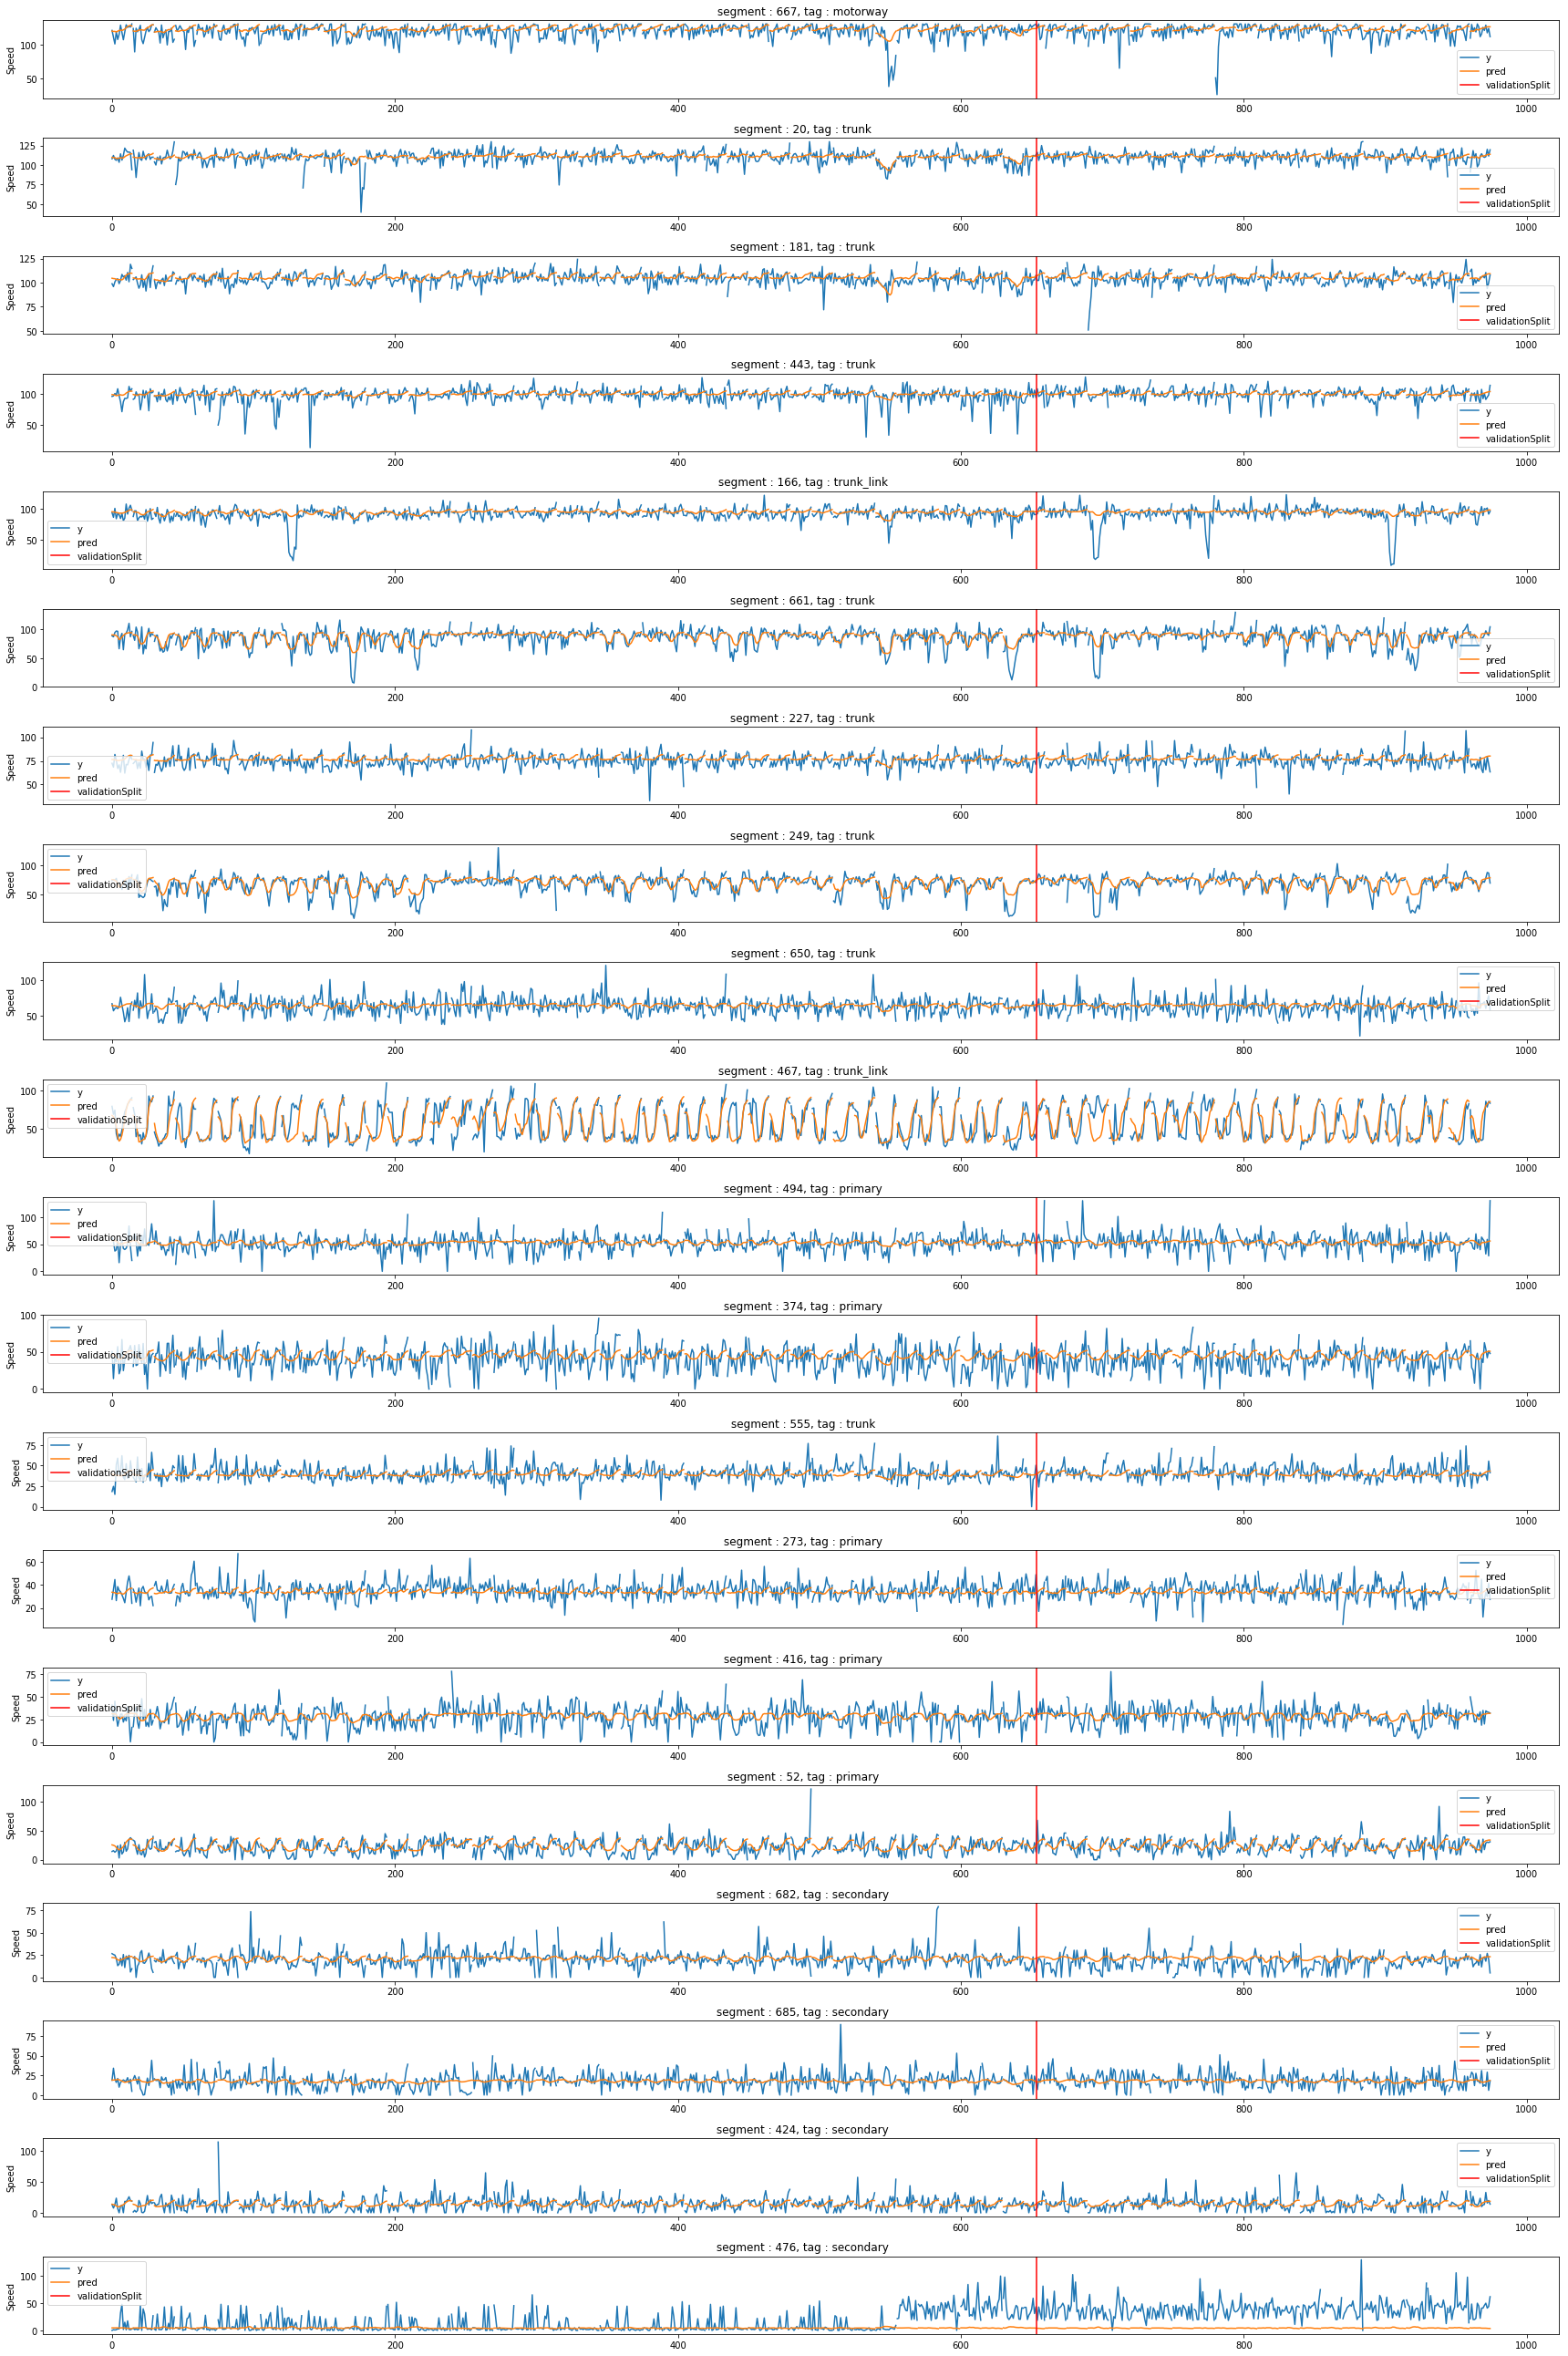

In [97]:
model_plotting3.plotMultipleSegmentsSeries(plot_error=False)

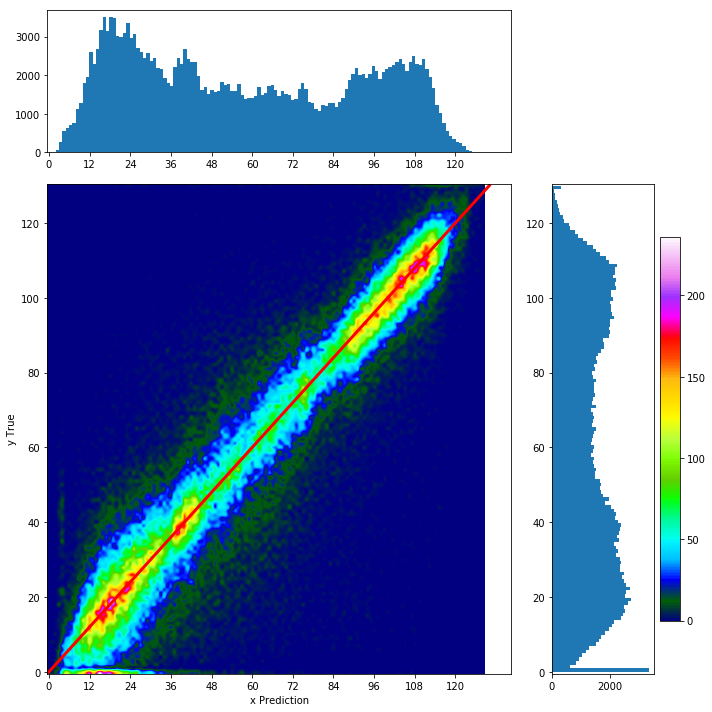

In [95]:
model_plotting3.plotPredictionMatchHeatMap("valid")

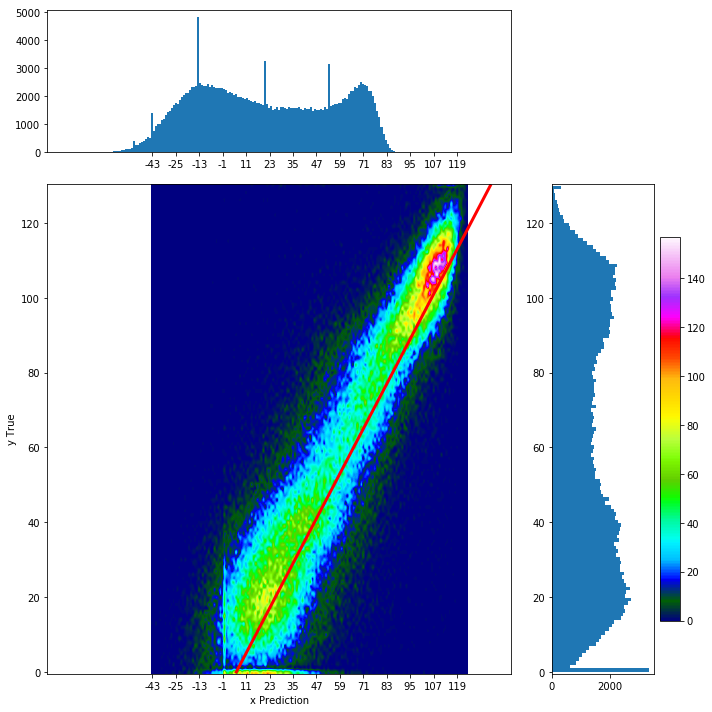

In [105]:
model_plotting3.plotPredictionMatchHeatMap("valid")

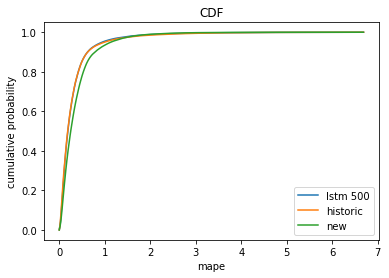

In [104]:
model_plotting3 = ModelPlots(data_model3, data_cleaner)
model_plotting2.cdfPlot(label="lstm 500")
model_plotting.cdfPlot(label="historic")
model_plotting3.cdfPlot(label='new')

# Simple NN to train

In [116]:
data_model4 = DataModel(speedDF, 1, output_lag, sequence_length, valid_split = valid_split, scale_max = True )
data_model4.preprocessData()
x_train4, y_train4, x_test4, y_test4 = data_model4.trainSplit()

In [157]:
y_train4[:,:10].shape

(827, 10)

In [158]:
x_train4 = x_train4[:,:,:10]
y_train4 = y_train4[:,:10]
x_test4 = x_test4[:,:,:10]
y_test4 = y_test4[:,:10]
x_test4.shape, x_train4.shape

((408, 1, 10), (827, 1, 10))

In [168]:
model4 = Sequential()
model4.add(Flatten(input_shape=(1, 10)))
model4.add(Dense(10, use_bias=False, activation='sigmoid'))

model4.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam())

data_model4.model = model4
data_model4.model.summary()

modelHist = data_model4.model.fit([x_train4],[y_train4],validation_data=([x_test4],y_test4), epochs=40)

print(data_model4.mse(data_model4.model.predict(x_train4),y_train4), data_model4.mse(data_model4.model.predict(x_test4),y_test4))
print(data_model4.mae(data_model4.model.predict(x_train4),y_train4), data_model4.mae(data_model4.model.predict(x_test4),y_test4))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_30 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 10)                100       
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Train on 827 samples, validate on 408 samples
Epoch 1/40
827/827 [==============================] - 5s 7ms/step - loss: 0.2841 - val_loss: 0.2720
Epoch 2/40
827/827 [==============================] - 0s 148us/step - loss: 0.2597 - val_loss: 0.2483
Epoch 3/40
827/827 [==============================] - 0s 153us/step - loss: 0.2369 - val_loss: 0.2259
Epoch 4/40
827/827 [==============================] - 0s 157us/step - loss: 0.2154 - val_loss: 0.2048
Epoch 5/40
827/827 [==============================] - 0s 136us/step - loss: 0.1952 - val

In [162]:
np.argmax(data_model4.model.layers[1].get_weights()[0][0])

6

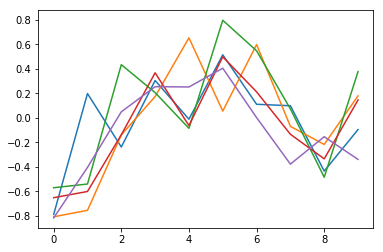

In [169]:
plt.plot(data_model4.model.layers[1].get_weights()[0][0])
plt.plot(data_model4.model.layers[1].get_weights()[0][1])
plt.plot(data_model4.model.layers[1].get_weights()[0][2])
plt.plot(data_model4.model.layers[1].get_weights()[0][3])
plt.plot(data_model4.model.layers[1].get_weights()[0][4])

In [174]:
[x['coordinates'] for x in segmentsMeta['loc'][:10]]

[[[-1.5522355, 48.086626],
  [-1.5518937, 48.0865131],
  [-1.5514566, 48.0864202],
  [-1.5509193, 48.0863303],
  [-1.5501941, 48.0862228],
  [-1.5497377, 48.0861397],
  [-1.5493502, 48.0860004],
  [-1.5487459, 48.0857426],
  [-1.5482598, 48.0855114],
  [-1.5480036, 48.0853448],
  [-1.5473698, 48.0848627],
  [-1.5472525, 48.0847451],
  [-1.5470939, 48.0845327],
  [-1.5468611, 48.084067],
  [-1.546635, 48.0835625],
  [-1.5465174, 48.0832545],
  [-1.5464784, 48.0830653],
  [-1.5464565, 48.0826873],
  [-1.5464553, 48.0824045],
  [-1.5464488, 48.080804],
  [-1.5464719, 48.0805042],
  [-1.5465488, 48.0802352],
  [-1.5470165, 48.0789864],
  [-1.5473375, 48.0781841],
  [-1.5473606, 48.0781283],
  [-1.547514, 48.0776632],
  [-1.5475722, 48.0774556],
  [-1.5475999, 48.0771898],
  [-1.5475977, 48.0768926],
  [-1.5475558, 48.0766223],
  [-1.5474405, 48.076238],
  [-1.5473577, 48.0760639],
  [-1.5471868, 48.0757921],
  [-1.5469915, 48.0754983],
  [-1.5467398, 48.0752518],
  [-1.5462781, 48.0748677]